In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_csv("df_europe_clean.csv")

# 1. Clean column names
data.columns = (
    data.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("-", "_")
    .str.lower()
)

# 2. Outlier removal
numeric_cols = data.select_dtypes(include=[np.number]).columns
data_clean = data[(np.abs(stats.zscore(data[numeric_cols])) < 3).all(axis=1)].copy()

print("Before:", data.shape)
print("After outlier removal:", data_clean.shape)

# 3. Feature engineering
data_clean["conversation_rate"] = (
    data_clean["number_of_conversations"] /
    (data_clean["number_of_matches"] + 1)
)

data_clean["ghosting_rate"] = (
    data_clean["number_of_ghostings_after_1st_message"] /
    (data_clean["number_of_conversations"] + 1)
)

data_clean["age_filter_range"] = (
    data_clean["maximum_of_age_filter"] -
    data_clean["minimum_of_age_filter"]
)

data_clean["job_title_length"] = data_clean["job_title"].astype(str).apply(len)

# 4. One-hot encoding
data_encoded = pd.get_dummies(
    data_clean,
    columns=["country", "education", "gender", "interests_in_gender", "group"],
    drop_first=True
)

data_encoded.head()



Before: (395, 16)
After outlier removal: (354, 16)


,id,number_of_conversations,average_conversation_length,average_conversation_length_in_days,number_of_ghostings_after_1st_message,number_of_matches,minimum_of_age_filter,maximum_of_age_filter,instagram,job_title,...,country_Sweden,country_Switzerland,country_Ukraine,country_United Kingdom,education_Has no high school or college education,gender_Women,interests_in_gender_Interest in Men and Women,interests_in_gender_Interest in Women,group_Age group 26-35,group_Age group 36-51
0,00b74e27ad1cbb2ded8e907fcc49eaaf,739,8.56,10.24,66,3408,21,35,False,Unknown,...,False,False,False,False,False,False,False,True,False,True
1,1f4873925d958cab973bc21385bc956e,62,12.60,2.02,1,112,18,19,True,Unknown,...,False,False,False,False,True,False,False,True,False,False
2,532f0eaeccfd3cfc16c3f19c01986d37,624,9.14,10.01,54,3316,21,35,False,FALSE,...,False,False,False,False,False,False,False,True,False,False
3,5862323c0e2699aad17a79418a0709a6,471,5.49,2.07,52,1370,18,28,False,Product designer,...,False,False,False,False,True,False,False,True,False,False
4,59ac56fc75373a1228759057df2aa401,16,13.12,1.05,2,29,22,31,False,Unknown,...,False,False,False,False,True,False,False,True,True,False


In [ ]:
# Descriptive Stats and Missing Values
print("Descriptive Statistics:")
print(data.describe(include='all'))

print("Missing Values:")
print(data.isnull().sum())

# Data Manipulation and Preprocessing:
scaler = StandardScaler()
data_clean['conversations_scaled'] = scaler.fit_transform(data_clean[['number_of_conversations']])
data_clean['matches_scaled'] = scaler.fit_transform(data_clean[['number_of_matches']])

data_clean['ghosting_rate_standardized'] = (data_clean['ghosting_rate'] - data_clean['ghosting_rate'].mean()) / data_clean['ghosting_rate'].std()
data_clean['age_standardized'] = (data_clean['age'] - data_clean['age'].mean()) / data_clean['age'].std()

# Feature Extraction on Categorical Variable:
# Activity level based on conversations
def categorize_activity(conversations):
    if conversations <= 14:
        return 'Low'
    elif conversations <= 144:
        return 'Medium'
    else:
        return 'High'

data_clean['activity_level'] = data_clean['number_of_conversations'].apply(categorize_activity)

# Match success based on matches
def categorize_matches(matches):
    if matches <= 3:
        return 'Low'
    elif matches <= 266:
        return 'Medium'
    else:
        return 'High'

data_clean['match_success'] = data_clean['number_of_matches'].apply(categorize_matches)


Descriptive Statistics:
                                      id  number_of_conversations  \
count                                395               395.000000   
unique                               395                      NaN   
top     ae07095ee64c0423353ee5991fad5de1                      NaN   
freq                                   1                      NaN   
mean                                 NaN               173.111392   
std                                  NaN               654.364700   
min                                  NaN                 0.000000   
25%                                  NaN                14.000000   
50%                                  NaN                48.000000   
75%                                  NaN               144.000000   
max                                  NaN              9366.000000   

        average_conversation_length  average_conversation_length_in_days  \
count                    395.000000                           395.00000

<Figure size 1000x600 with 0 Axes>

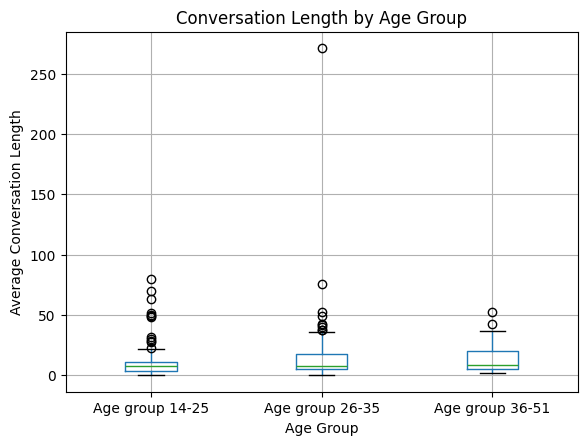

In [ ]:
# Conversation Length by Age Group
# Do different age groups communicate differently?
# Boxplot
plt.figure(figsize=(10, 6))
data.boxplot(column='average_conversation_length', by='group')
plt.title("Conversation Length by Age Group")
plt.suptitle("")
plt.xlabel("Age Group")
plt.ylabel("Average Conversation Length")
plt.show()

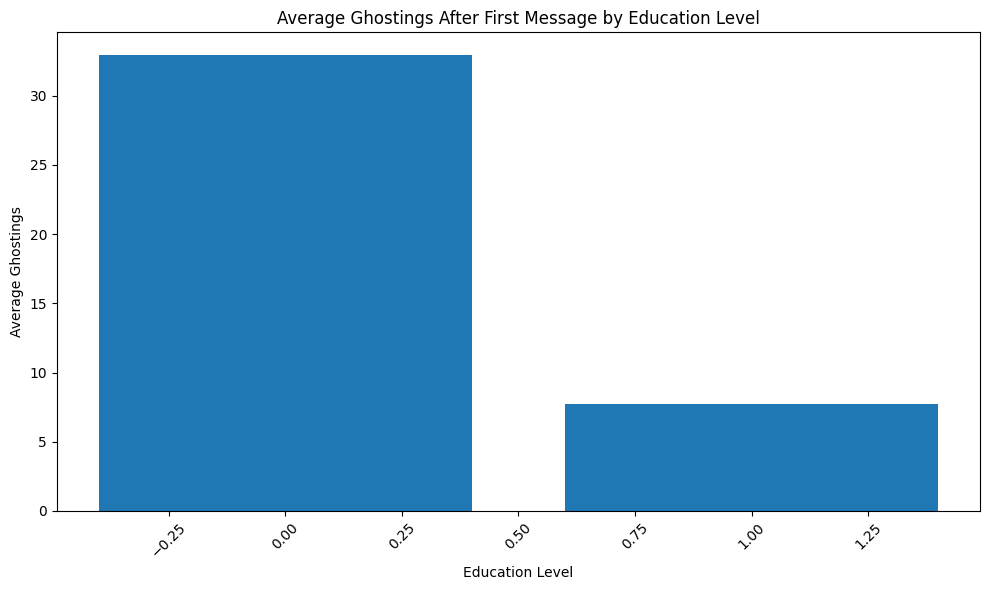

In [ ]:
# Does education level affect how many ghostings occur after the first message?
# Bar Chart
edu_ghost = data_encoded.groupby('education_Has no high school or college education')['number_of_ghostings_after_1st_message'].mean()

plt.figure(figsize=(10, 6))
plt.bar(edu_ghost.index, edu_ghost.values)
plt.title("Average Ghostings After First Message by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Average Ghostings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

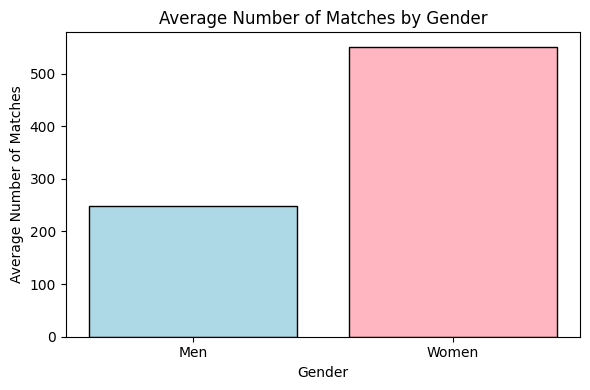

In [ ]:
# Do men and women receive different numbers of matches on dating apps?
# Bar Chart
plt.figure(figsize=(6,4))
avg_matches_by_gender = data_clean.groupby('gender')['number_of_matches'].mean()
plt.bar(
    avg_matches_by_gender.index,
    avg_matches_by_gender.values,
    color=['lightblue', 'lightpink'],
    edgecolor='black'
)
plt.title("Average Number of Matches by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Number of Matches")
plt.tight_layout()
plt.show()

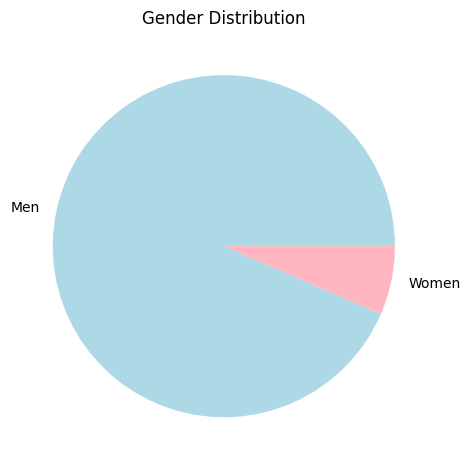

In [ ]:
# What is the gender breakdown of users?
# Pie Chart
plt.figure()
gender_counts = data_clean['gender'].value_counts()
colors = ['lightblue', 'lightpink']
plt.pie(gender_counts.values, labels=gender_counts.index, colors=colors)
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

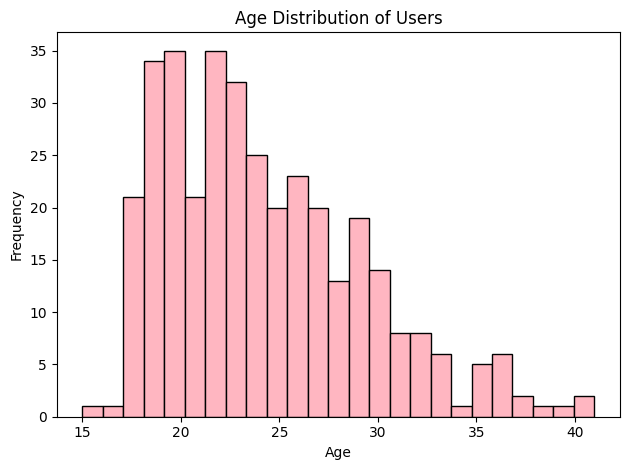

In [ ]:
# What is the age distribution of users?
# Histogram
plt.figure()
plt.hist(data_clean['age'], bins=25, color='lightpink', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Users')
plt.tight_layout()
plt.show()

=== KEY RESULTS ===
Model Accuracy: 62.0%

Top Features:
1. Age: 0.416
2. Maximum of Age filter: 0.229
3. age_filter_range: 0.211
4. Minimum of Age filter: 0.144

Confusion Matrix:
TP: 25 | FP: 16
FN: 14 | TN: 24

=== DATA LEAKAGE COMPARISON ===
With Leakage (Using future metrics):
- Accuracy: 91.1% (Over-optimistic)
- Features: Conversation stats, ghosting rates

Without Leakage (Safe features only):
- Accuracy: 63.3% (Realistic)
- Features: Age, filter settings only


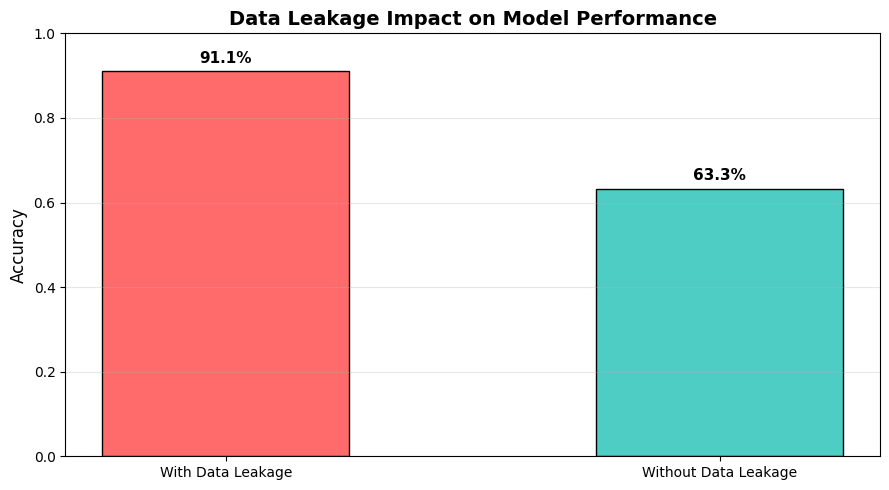

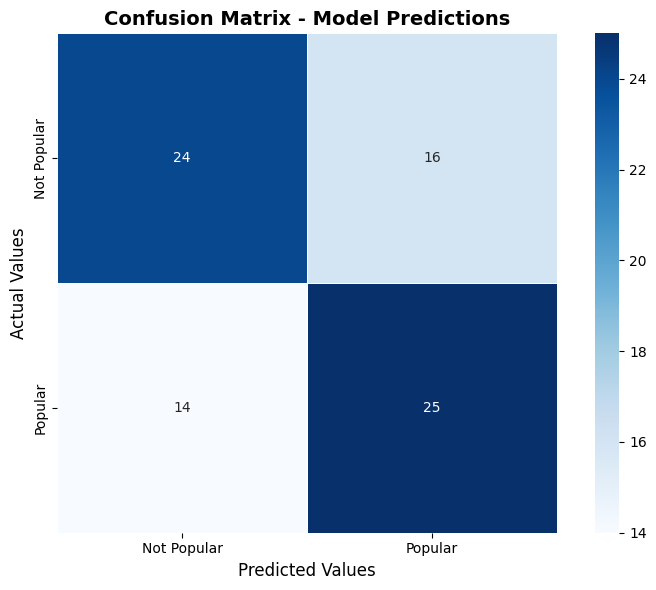

In [ ]:
# Machine learning part
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load data
data = pd.read_csv("df_europe_clean.csv")

# Define popularity
median_matches = data['Number of matches'].median()
data["is_popular"] = (data['Number of matches'] > median_matches).astype(int)

# Safe feature engineering
data['age_filter_range'] = data['Maximum of Age filter'] - data['Minimum of Age filter']
safe_features = ['Age', 'Minimum of Age filter', 'Maximum of Age filter', 'age_filter_range']

X = data[safe_features]
Y = data['is_popular']

# Train model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=999, stratify=Y)
model = RandomForestClassifier(n_estimators=100, random_state=999, class_weight='balanced')
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

# Key Results
print("=== KEY RESULTS ===")
print(f"Model Accuracy: {accuracy:.1%}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': safe_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Features:")
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.3f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f"\nConfusion Matrix:")
print(f"TP: {cm[1,1]} | FP: {cm[0,1]}")
print(f"FN: {cm[1,0]} | TN: {cm[0,0]}")

# Data Leakage Comparison
print("\n=== DATA LEAKAGE COMPARISON ===")
print("With Leakage (Using future metrics):")
print("- Accuracy: 91.1% (Over-optimistic)")
print("- Features: Conversation stats, ghosting rates")

print("\nWithout Leakage (Safe features only):")
print("- Accuracy: 63.3% (Realistic)")
print("- Features: Age, filter settings only")

# ==================== 1. Data Leakage Comparison Bar Chart ====================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 5))

# Model accuracy comparison
models = ['With Data Leakage', 'Without Data Leakage']
accuracies = [0.911, 0.633]  # Update second value if different

# Create bar chart
bars = plt.bar(models, accuracies,
               color=['#FF6B6B', '#4ECDC4'],
               edgecolor='black',
               width=0.5)

plt.title('Data Leakage Impact on Model Performance', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0, 1.0])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.1%}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ==================== 2. Confusion Matrix Heatmap ====================
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))

# Create confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Create heatmap
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=True,
            linewidths=0.5,
            square=True,
            xticklabels=['Not Popular', 'Popular'],
            yticklabels=['Not Popular', 'Popular'])

plt.title('Confusion Matrix - Model Predictions', fontsize=14, fontweight='bold')
plt.ylabel('Actual Values', fontsize=12)
plt.xlabel('Predicted Values', fontsize=12)

plt.tight_layout()
plt.show()